In [2]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [4]:
import importlib

## Preprocessing
### Read data

In [4]:
import gzip
import shutil
data_dir = "../../data/BacDrop/raw_data/"
file_names = ["GSM5456486_MGH66_Abx3_P1_align2._CDS.tsv", "GSM6081205_Abx2_S2_P1_CDS.tsv"]

for f in file_names:
    file_name_full = data_dir + f

    if not f in os.listdir(data_dir):
        if f + ".gz" in os.listdir(data_dir):
            print("unzipping data...")
            with gzip.open(file_name_full + ".gz","rb") as f_in, open(file_name_full,"wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        else:
            raise FileNotFoundError(f"{f} does not exist in regular or zipped form")

In [5]:
adatas = []
for f in file_names:
    file_name_full = data_dir + f
    adata = sc.read_csv(file_name_full, delimiter="\t", first_column_names=True)
    adata = adata.transpose()
    adata.var_names_make_unique()
    adata.X = sps.csr_matrix(adata.X)
    adatas.append(adata)
    
adatas

[AnnData object with n_obs × n_vars = 410143 × 4066,
 AnnData object with n_obs × n_vars = 47915 × 3900]

In [6]:
adatas[0].obs["treatment"] = "untreated"
adatas[1].obs["treatment"] = "untreated"
adatas[0].obs["replicate"] = 1
adatas[1].obs["replicate"] = 2

In [7]:
data_untr = ad.concat(adatas, join="outer", fill_value=0)
data_untr

AnnData object with n_obs × n_vars = 458058 × 4293
    obs: 'treatment', 'replicate'

In [8]:
print(f"Zero inflation of data: {((np.prod(data_untr.X.shape) - data_untr.X.getnnz()) / np.prod(data_untr.X.shape)).round(3)}")


Zero inflation of data: 0.998


### Filter cells

--> filter based on mean absolute standard deviation

In [9]:
importlib.reload(ut)
data_gene = data_untr.copy()
# sc.pp.filter_cells(data_gene, min_genes=15)
# sc.pp.filter_genes(data_gene, min_cells=2)
# sc.pp.calculate_qc_metrics(data_gene, var_type="genes", percent_top=None, log1p=True, inplace=True)

data_gene = ut.filter_outliers(data_untr, nmads=15, min_cells=2, min_genes=15)
# print(data_untr.obs.outlier.value_counts())
print(f"Total number of cells: {data_untr.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

Total number of cells: 458058
Number of cells after filtering: 48511


AnnData object with n_obs × n_vars = 48511 × 3687
    obs: 'treatment', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

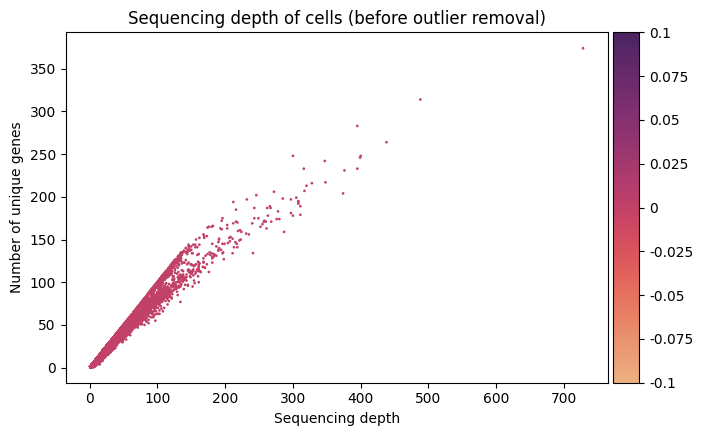

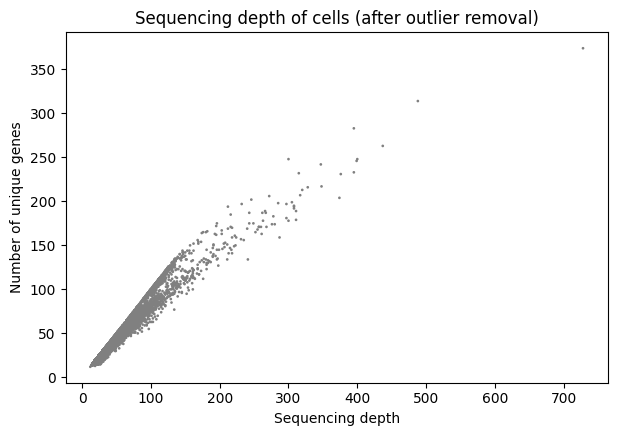

In [10]:
g = sc.pl.scatter(data_untr, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [11]:
data_gene.layers["counts"] = data_gene.X.copy()

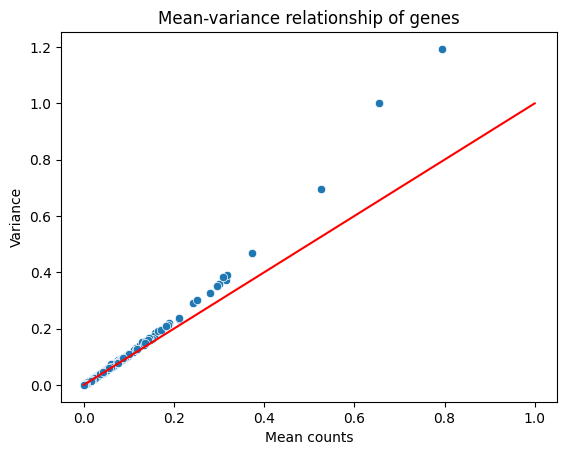

In [12]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [13]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [14]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [15]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
cds-AF52_RS00165                    2     0.000041           0.000041   
cds-AF52_RS00180                    2     0.000041           0.000041   
cds-AF52_RS00275                   27     0.000577           0.000577   
cds-AF52_RS00620                   44     0.000928           0.000927   
cds-AF52_RS01000                  293     0.006081           0.006063   
...                               ...          ...                ...   
cds-WP_187079192.1                735     0.015378           0.015261   
cds-WP_187079193.1                182     0.003814           0.003806   
cds-WP_187079194.1                 93     0.001958           0.001956   
cds-WP_187079196.1                 26     0.000536           0.000536   
cds-WP_187079197.1                  2     0.000041           0.000041   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  \
cds-AF52_RS00165                99.995877           2.0            1.098612   
cds-AF52_RS00180                99.995877           2.0            1.098612   
cds-AF52_RS00275                99.944343          28.0            3.367296   
cds-AF52_RS00620                99.909299          45.0            3.828641   
cds-AF52_RS01000                99.396013         295.0            5.690360   
...                                   ...           ...                 ...   
cds-WP_187079192.1              98.484880         746.0            6.616065   
cds-WP_187079193.1              99.624827         185.0            5.225747   
cds-WP_187079194.1              99.808291          95.0            4.564348   
cds-WP_187079196.1              99.946404          26.0            3.295837   
cds-WP_187079197.1              99.995877           2.0            1.098612   

                    n_cells  var_counts  is_scd_outlier  nb_overdisp  \
cds-AF52_RS00165          2    0.000041           False     0.000078   
cds-AF52_RS00180          2    0.000041           False     0.000078   
cds-AF52_RS00275         27    0.000618           False     0.015278   
cds-AF52_RS00620         44    0.000967           False     0.021351   
cds-AF52_RS01000        293    0.006126           False     0.178261   
...                     ...         ...             ...          ...   
cds-WP_187079192.1      735    0.015597           False     0.812126   
cds-WP_187079193.1      182    0.003965           False     0.119991   
cds-WP_187079194.1       93    0.002039           False     0.064837   
cds-WP_187079196.1       26    0.000536           False     0.013513   
cds-WP_187079197.1        2    0.000041           False     0.000078   

                    nb_overdisp_cutoff    nb_mean    nb_umi  \
cds-AF52_RS00165              0.010000 -12.210792  1.285566   
cds-AF52_RS00180              0.010000 -12.210792  1.285566   
cds-AF52_RS00275              0.015278 -10.284860  1.965855   
cds-AF52_RS00620              0.021351  -9.064961  1.470136   
cds-AF52_RS01000              0.178261  -8.607370  2.399019   
...                                ...        ...       ...   
cds-WP_187079192.1            0.812126 -12.774071  5.424723   
cds-WP_187079193.1            0.119991  -9.107463  2.417071   
cds-WP_187079194.1            0.064837  -9.416389  2.193500   
cds-WP_187079196.1            0.013513 -10.368819  1.983307   
cds-WP_187079197.1            0.010000 -12.210792  1.285566   

                    Intercept_step1_sct  log_umi_step1_sct  \
cds-AF52_RS00165             -11.704462           1.146451   
cds-AF52_RS00180             -13.066889           2.080146   
cds-AF52_RS00275             -10.497307           2.126683   
cds-AF52_RS00620              -8.321948           0.957731   
cds-AF52_RS01000             -13.590407           5.382544   
...                                 ...                ...   
cds-WP_187079192.1           -13.021833           5.569577   
cds-WP_187079193.1                  NaN                NaN   
cds-WP_1870791

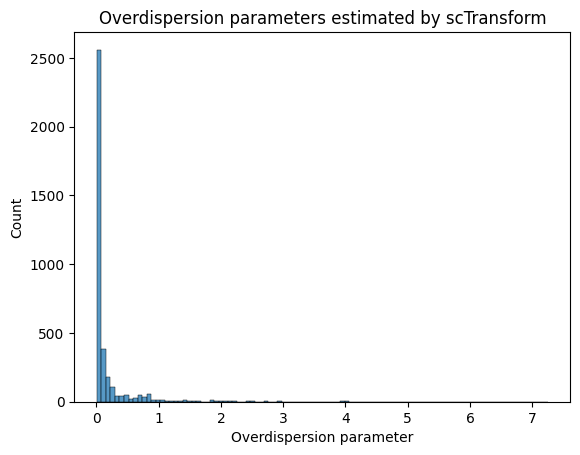

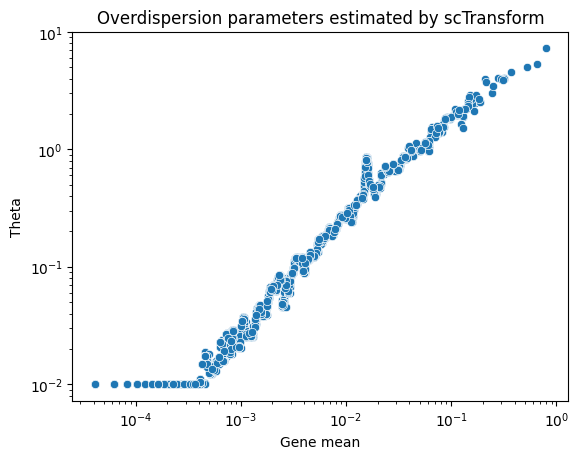

In [16]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [17]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [18]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.pp.highly_variable_genes(data_gene, n_top_genes=2500, flavor="seurat_v3", layer="counts")
data_gene = data_gene[:, data_gene.var.highly_variable]

# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

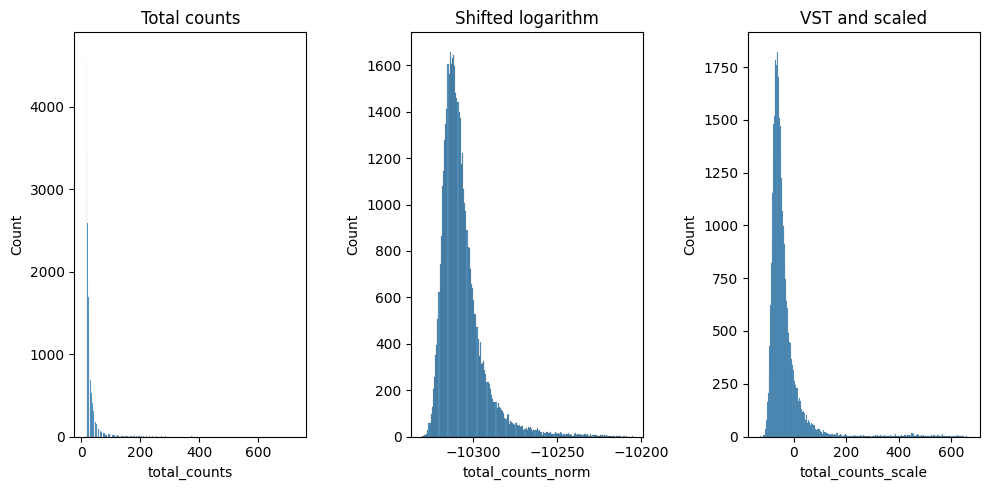

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [8]:
is_overdispersed=False
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 48506 × 2092
    obs: 'treatment', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'lt'
    layers: 'counts'


In [9]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

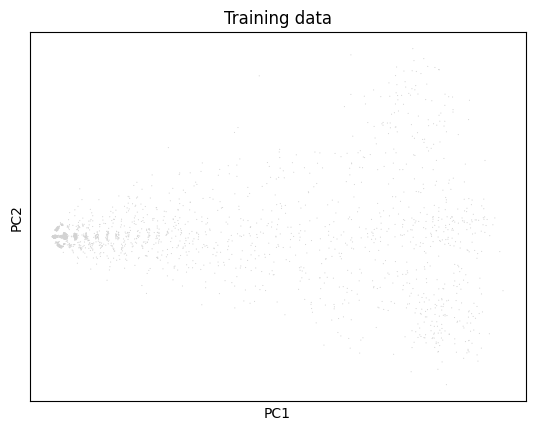

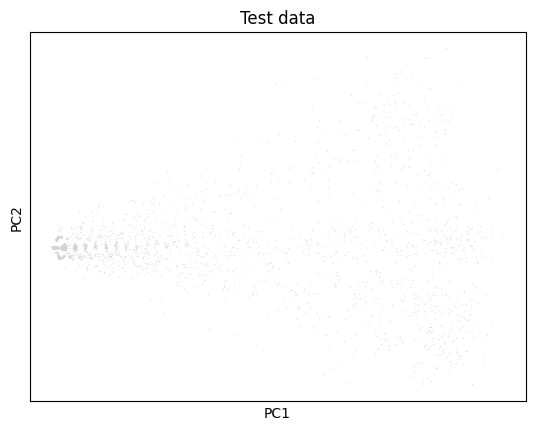

In [10]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [23]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


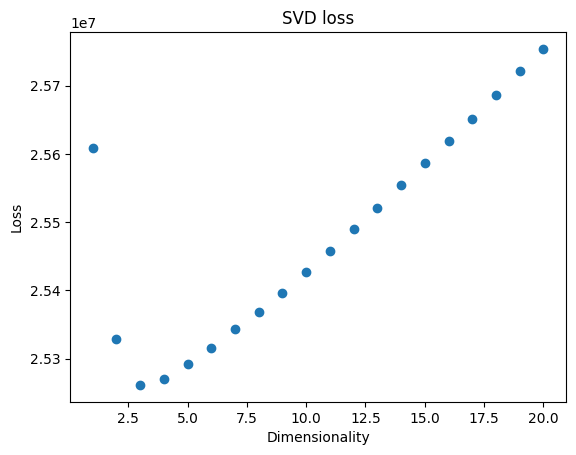

In [24]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

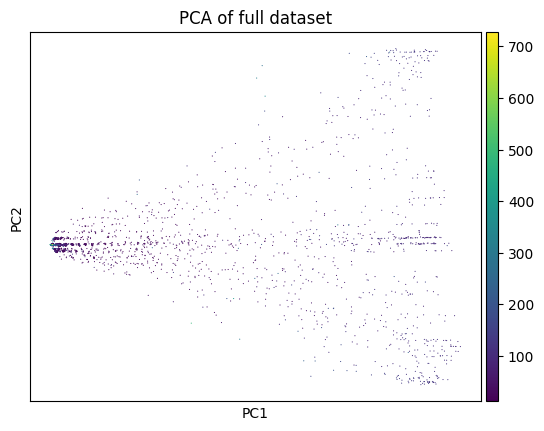

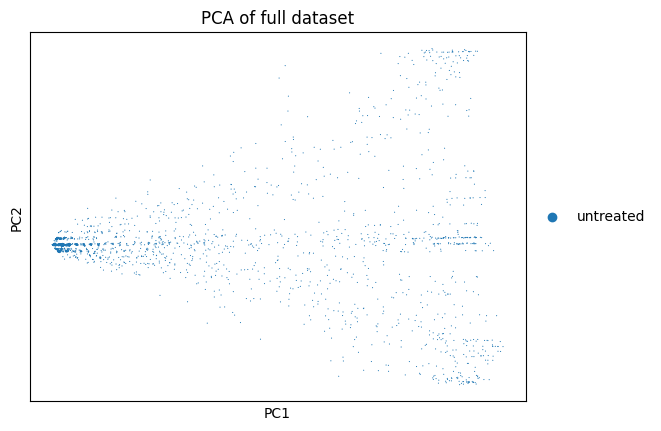

In [25]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

sc.pl.pca(data_gene, color="treatment", cmap="viridis", title="PCA of full dataset")
plt.show()

In [26]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [27]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

806


In [ ]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="Klebs_untreated_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85


Optimal number of neighbors: 70
Optimal min_dist: 0.05


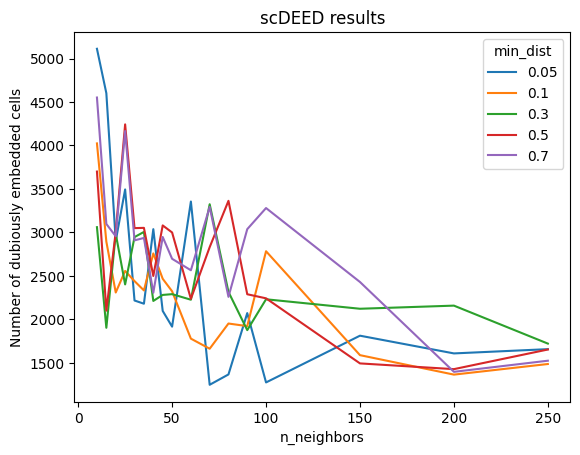

In [55]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [12]:
k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


# k_opt = 3
# n_neighbors_opt = 30
# min_dist_opt = 0.3
print(k_opt)

3


In [ ]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [ ]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


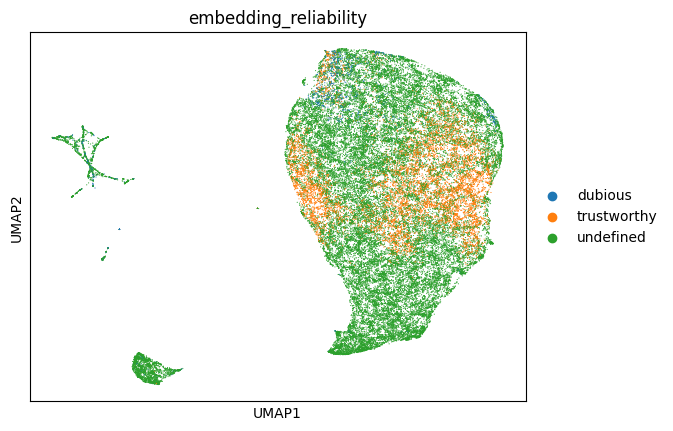

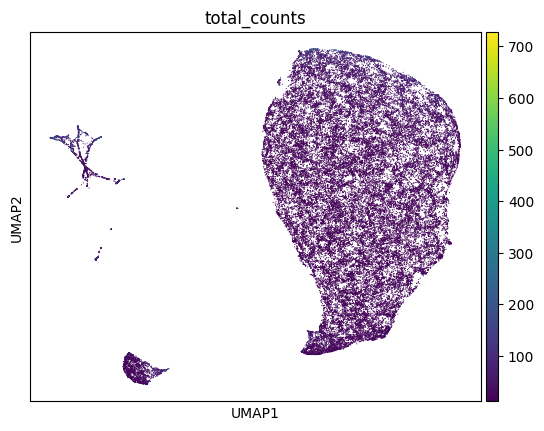

In [58]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

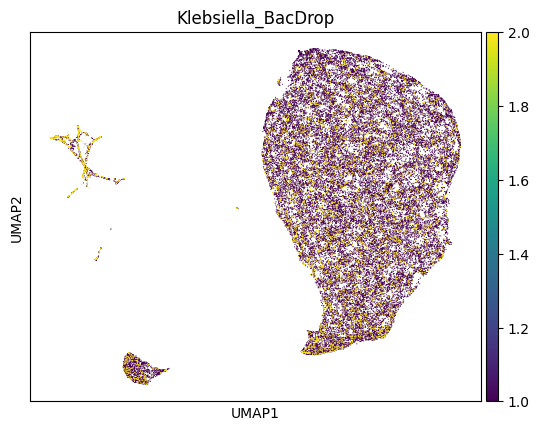

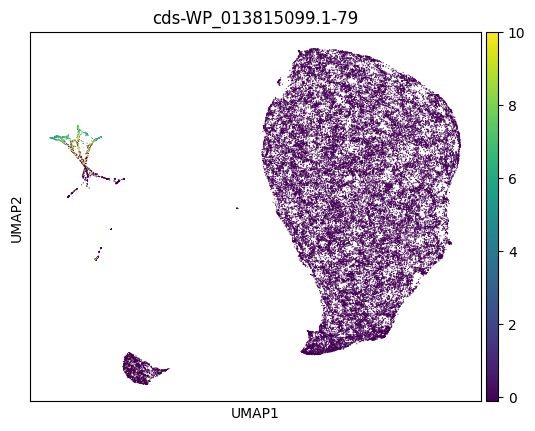

In [59]:
sc.pl.umap(data_gene, color="replicate", palette="tab10", title="Klebsiella_BacDrop")
plt.show()

tag = "cds-WP_013815099.1-79"
sc.pl.umap(data_gene, color=tag)
plt.show()

In [ ]:
# data_gene.write(data_path + "/untreated_data_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [5]:
data_path = "../../data/BacDrop/"
data_gene = sc.read_h5ad(data_path + "/untreated_data_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 48511 × 2500
    obs: 'treatment', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'lt'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'hvg', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [13]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=2345)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=2345)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

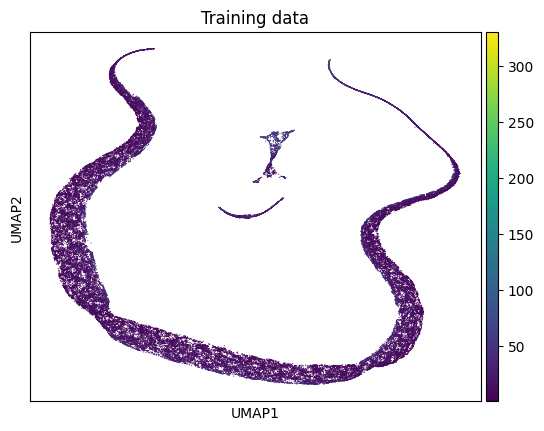

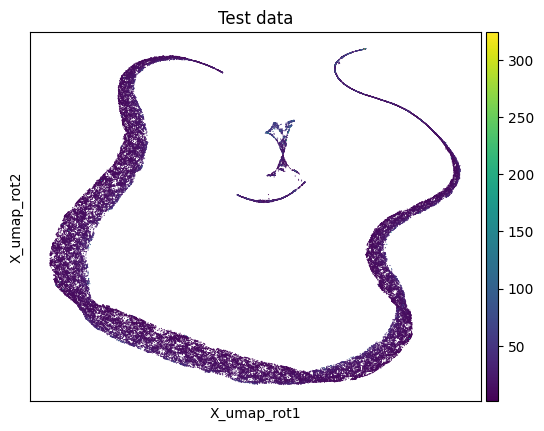

In [14]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [15]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=2345)

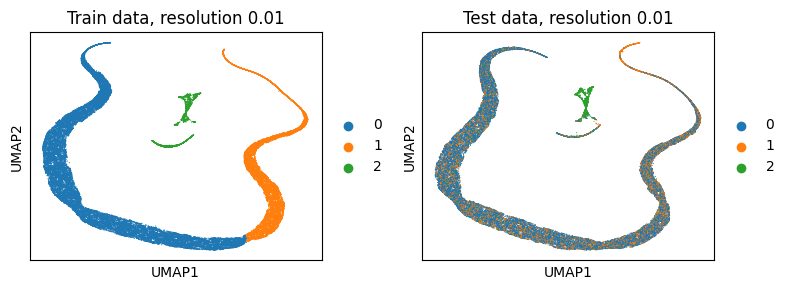

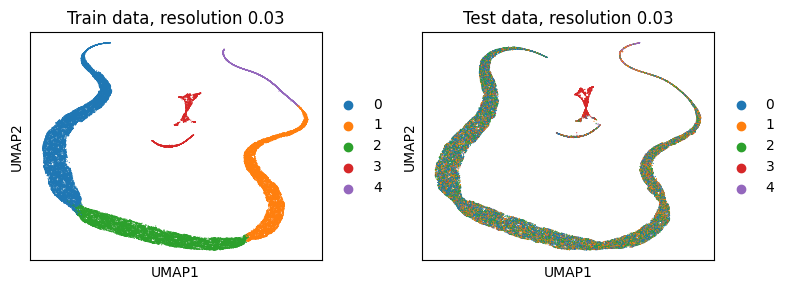

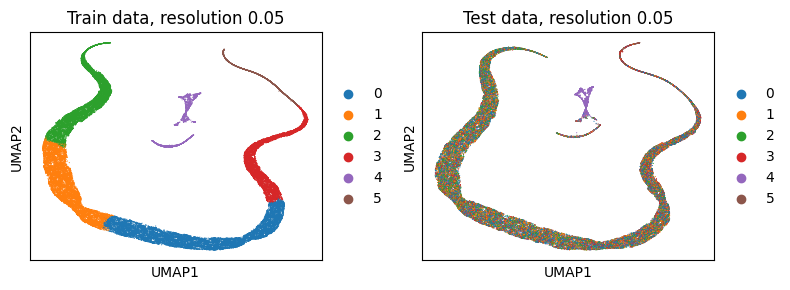

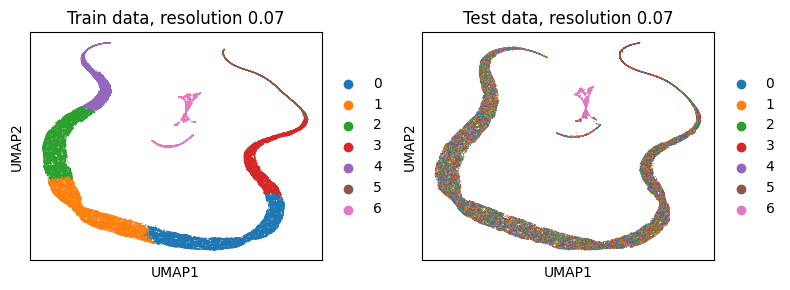

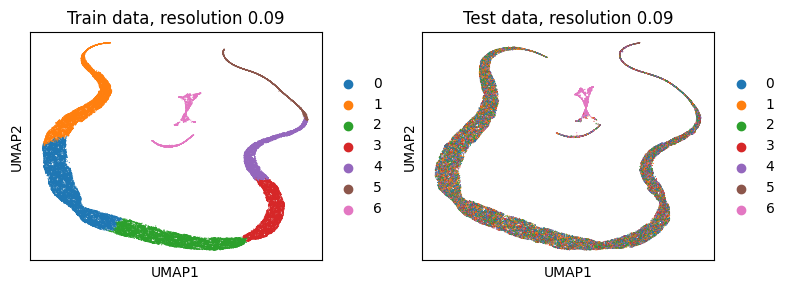

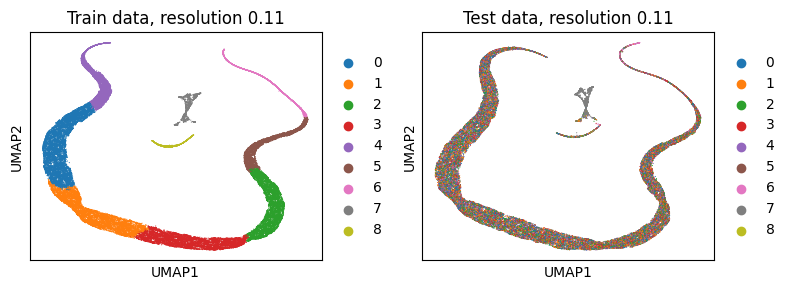

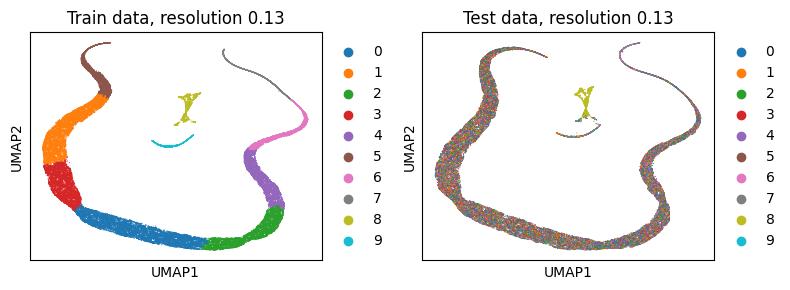

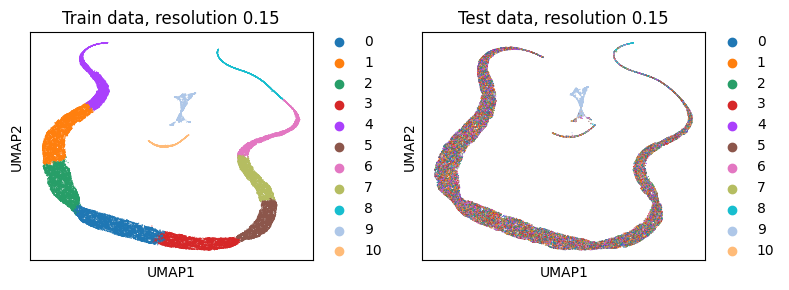

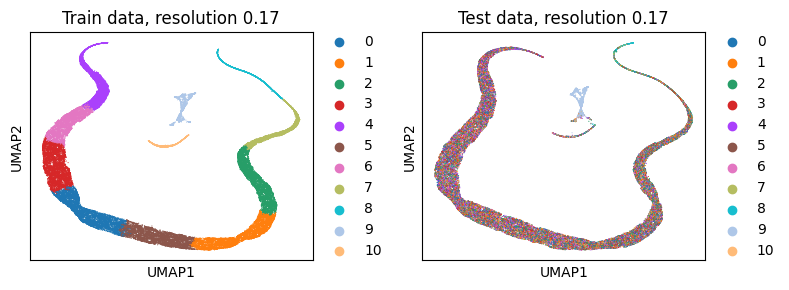

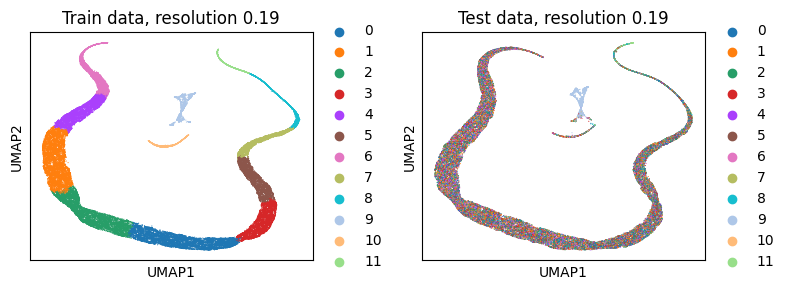

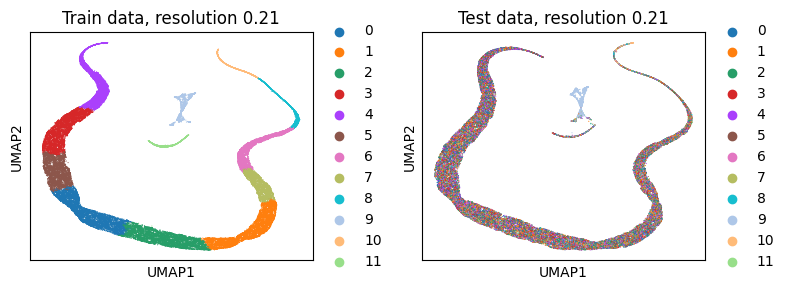

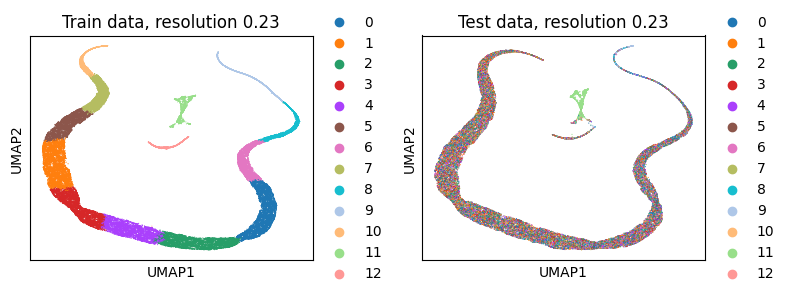

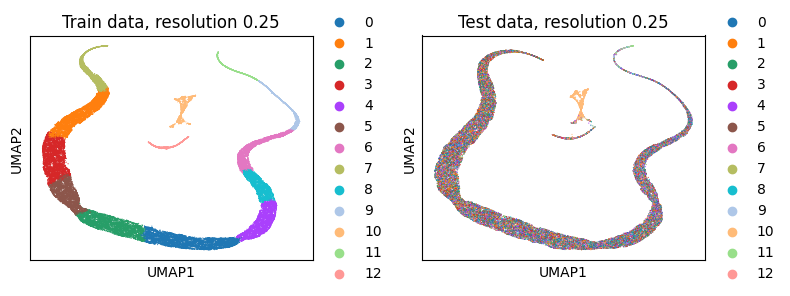

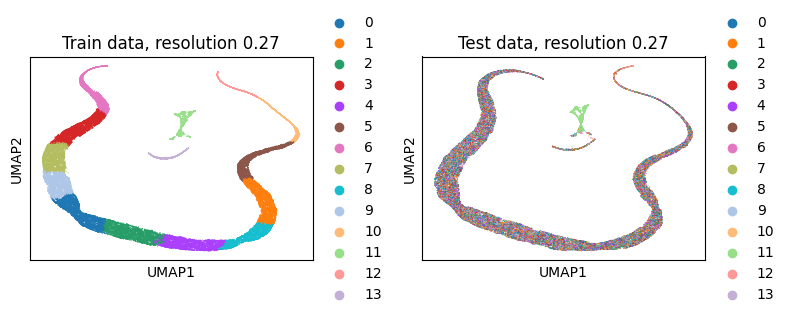

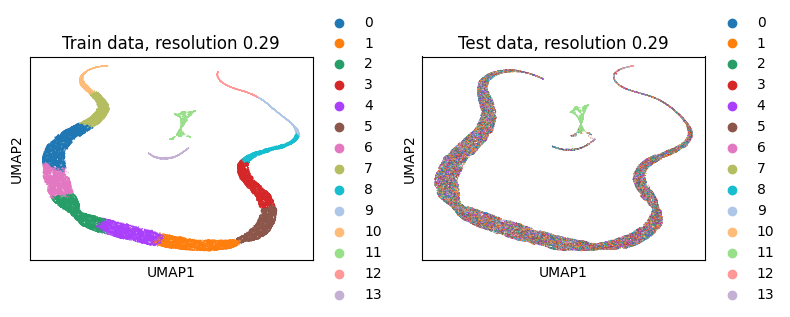

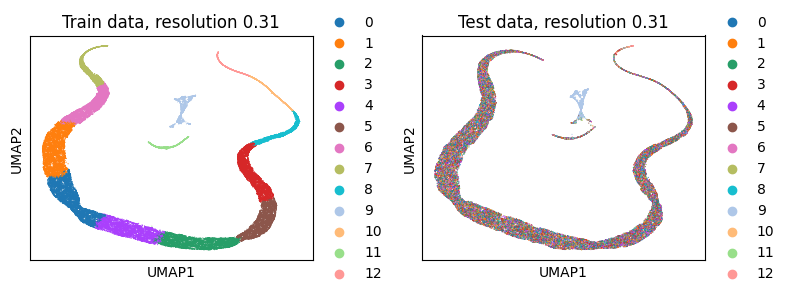

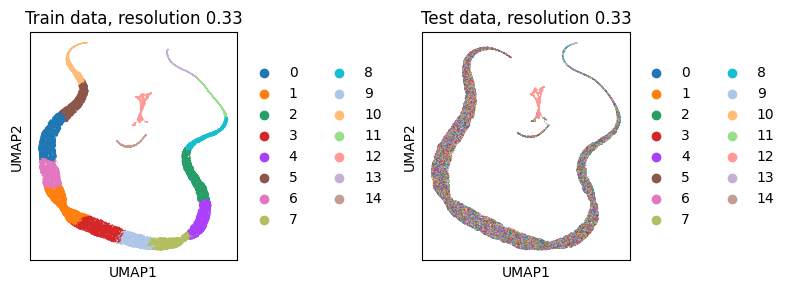

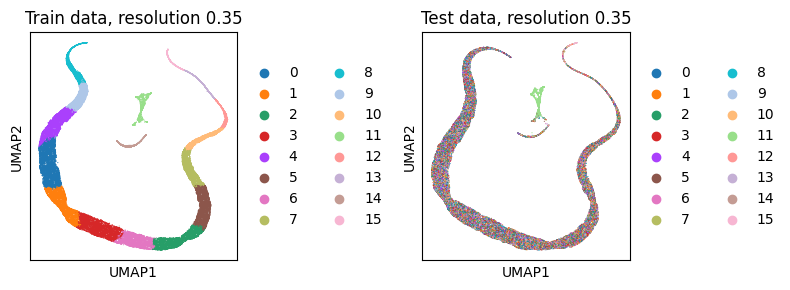

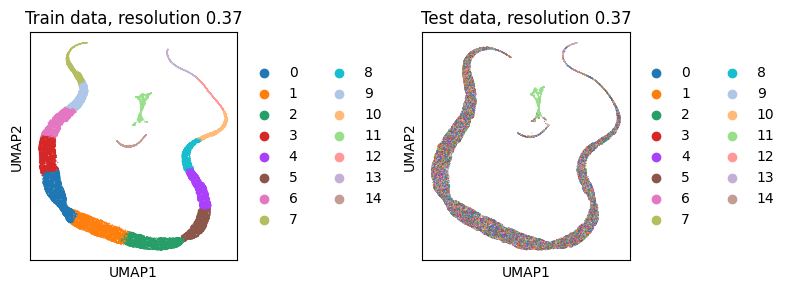

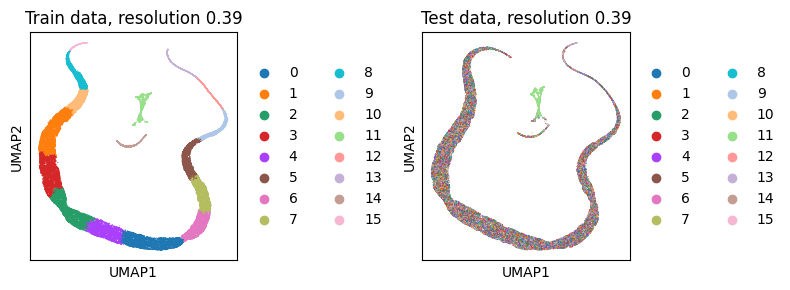

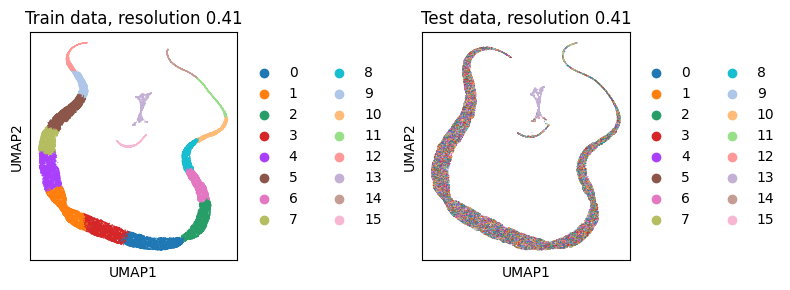

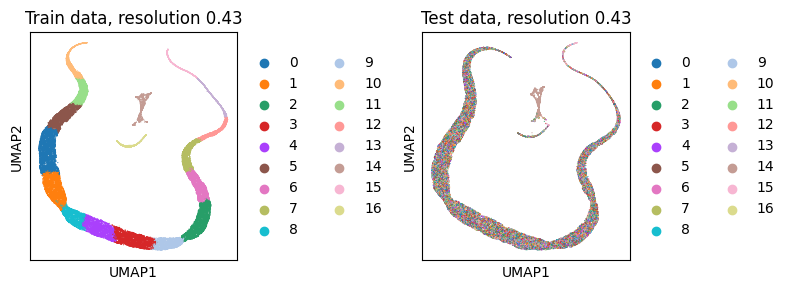

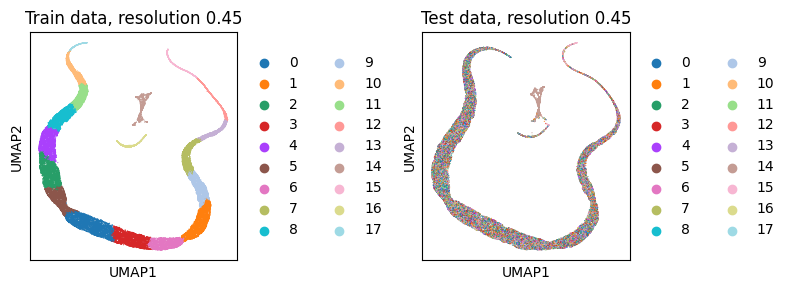

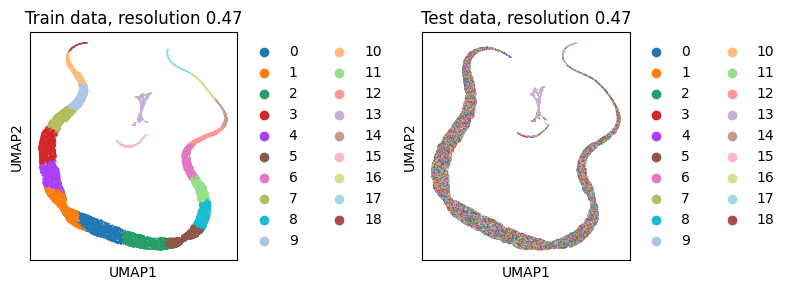

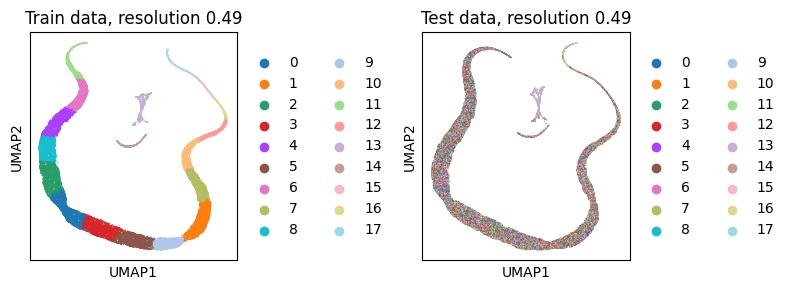

In [16]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [17]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=2345)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 3 - Train: 0.493 - Test: 0.28 - Random: 0.242
resolution: 0.03 - clusters: 5 - Train: 0.486 - Test: 0.158 - Random: 0.13
resolution: 0.05 - clusters: 6 - Train: 0.482 - Test: 0.12 - Random: 0.095
resolution: 0.07 - clusters: 7 - Train: 0.478 - Test: 0.097 - Random: 0.073
resolution: 0.09 - clusters: 7 - Train: 0.475 - Test: 0.095 - Random: 0.07
resolution: 0.11 - clusters: 9 - Train: 0.473 - Test: 0.078 - Random: 0.055
resolution: 0.13 - clusters: 10 - Train: 0.47 - Test: 0.07 - Random: 0.048
resolution: 0.15 - clusters: 11 - Train: 0.469 - Test: 0.059 - Random: 0.037
resolution: 0.17 - clusters: 11 - Train: 0.466 - Test: 0.056 - Random: 0.035
resolution: 0.19 - clusters: 12 - Train: 0.464 - Test: 0.054 - Random: 0.033
resolution: 0.21 - clusters: 12 - Train: 0.462 - Test: 0.05 - Random: 0.03
resolution: 0.23 - clusters: 13 - Train: 0.461 - Test: 0.045 - Random: 0.025
resolution: 0.25 - clusters: 13 - Train: 0.459 - Test: 0.043 - Random: 0.023
resolution: 0

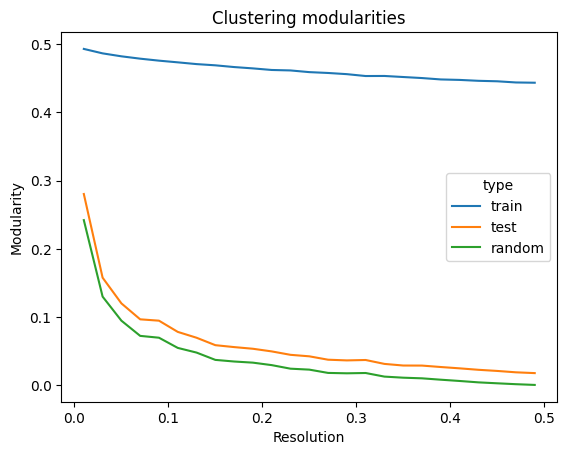

In [18]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

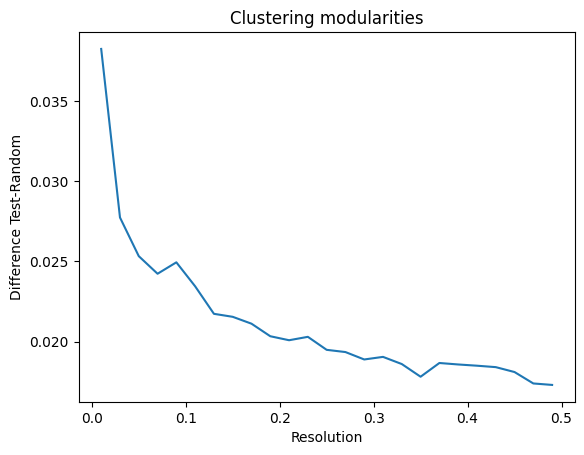

In [19]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [71]:
result_path = "Klebs_untreated_clustering"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [21]:
res_opt=0.03

In [22]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt", random_state=2345)

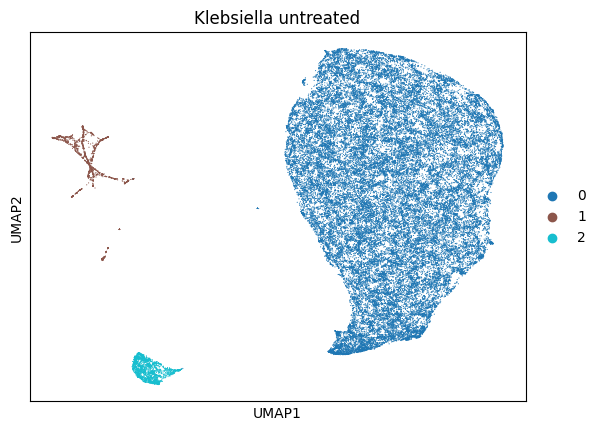

In [25]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Klebsiella untreated")
plt.show()

In [26]:
data_path = "../../data/BacDrop"

data_gene.write(data_path + "/untreated_data_processed.h5ad")

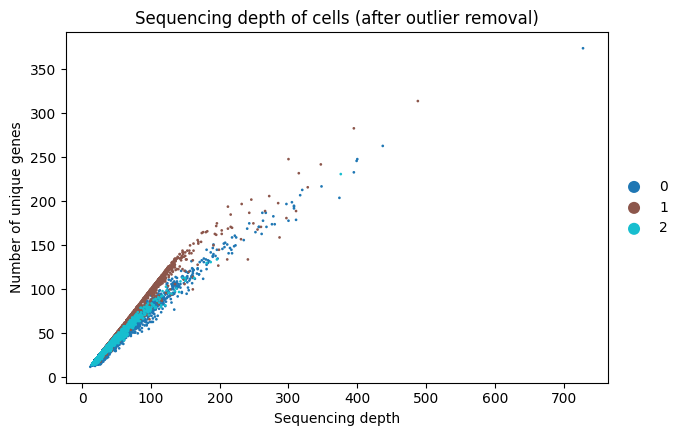

In [27]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

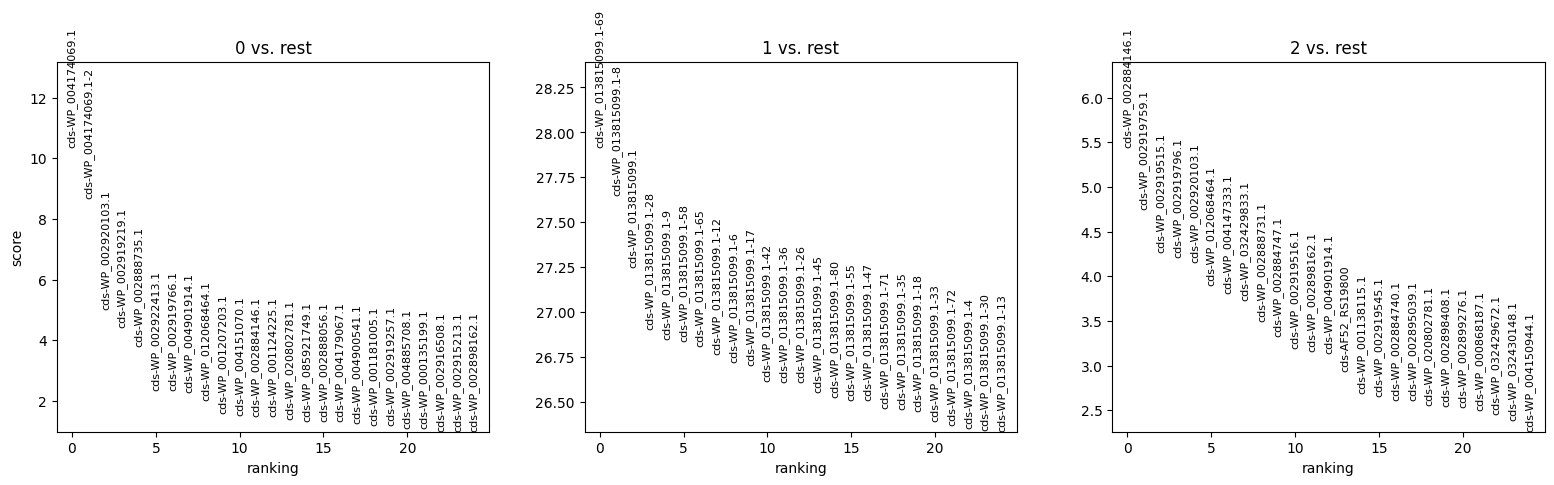

In [28]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

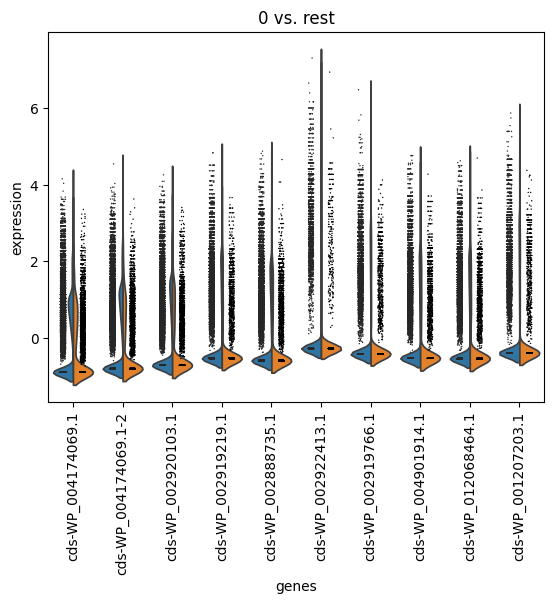

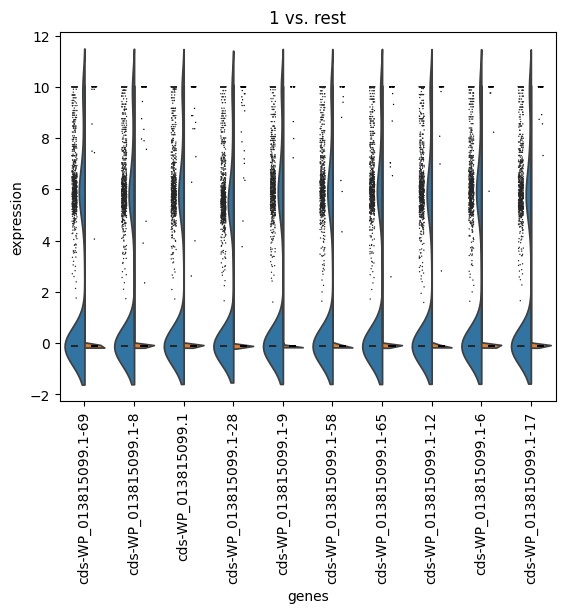

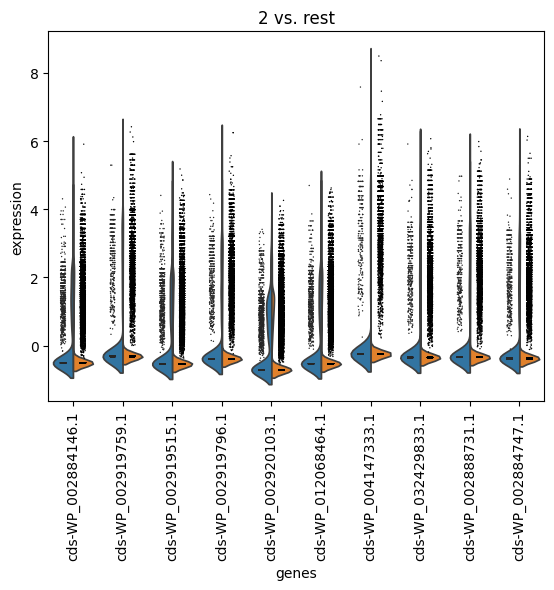

In [29]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

In [30]:
top_genes_1 = [x[1] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_1[:25])

['cds-WP_013815099.1-69', 'cds-WP_013815099.1-8', 'cds-WP_013815099.1', 'cds-WP_013815099.1-28', 'cds-WP_013815099.1-9', 'cds-WP_013815099.1-58', 'cds-WP_013815099.1-65', 'cds-WP_013815099.1-12', 'cds-WP_013815099.1-6', 'cds-WP_013815099.1-17', 'cds-WP_013815099.1-42', 'cds-WP_013815099.1-36', 'cds-WP_013815099.1-26', 'cds-WP_013815099.1-45', 'cds-WP_013815099.1-80', 'cds-WP_013815099.1-55', 'cds-WP_013815099.1-47', 'cds-WP_013815099.1-71', 'cds-WP_013815099.1-35', 'cds-WP_013815099.1-18', 'cds-WP_013815099.1-33', 'cds-WP_013815099.1-72', 'cds-WP_013815099.1-4', 'cds-WP_013815099.1-30', 'cds-WP_013815099.1-13']


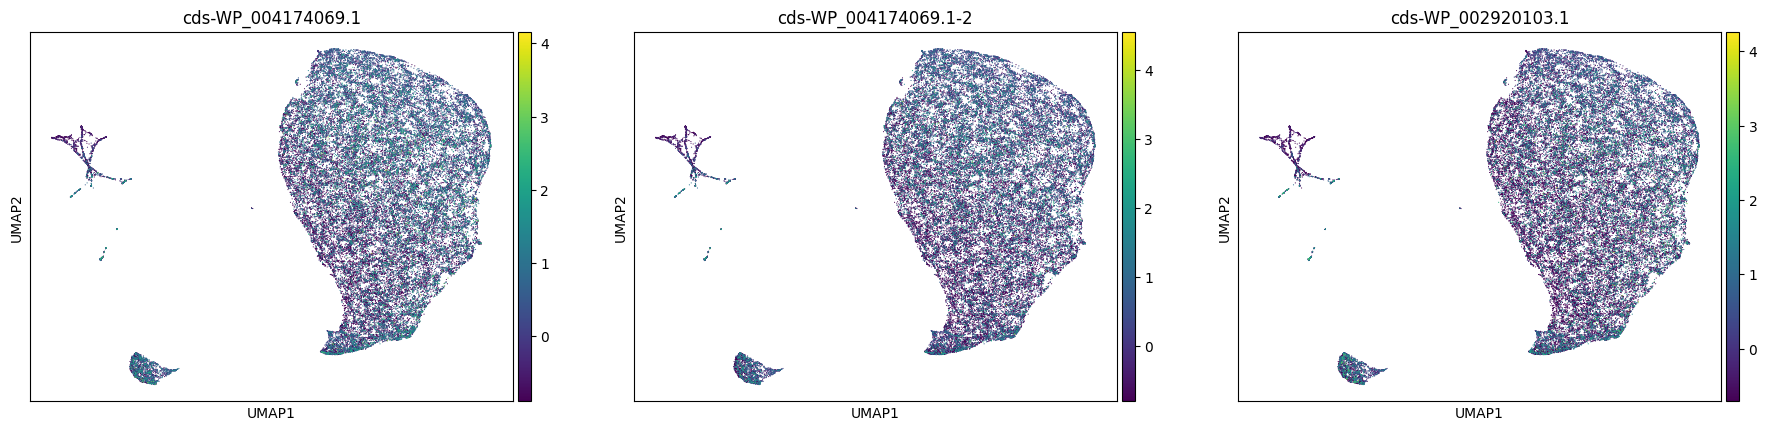

In [31]:
high_expr_genes = ["cds-WP_004174069.1", "cds-WP_004174069.1-2", "cds-WP_002920103.1"]
sc.pl.umap(data_gene, color=high_expr_genes)
plt.show()

## Attach feature table

In [32]:
data_path = "../../data/BacDrop/"
data_gene = sc.read_h5ad(data_path + "/untreated_data_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 48511 × 2500
    obs: 'treatment', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'lt'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'hvg', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [33]:
feature_table = pd.read_csv(data_path + "genomic_information/klebsiella_MGH66/GCF_000694555.1_Kleb_pneu_MGH_66_V1_feature_table.txt", sep="\t")
feature_table = feature_table[feature_table["# feature"] == "CDS"][["locus_tag", "product_accession", "name", "symbol"]]

feature_table

locus_tag product_accession  \
1       AF52_RS22895    WP_228690219.1   
3       AF52_RS22890               NaN   
5       AF52_RS26590               NaN   
7       AF52_RS26600               NaN   
9     AF52_RS0122900               NaN   
...              ...               ...   
9857    AF52_RS00020    WP_021441167.1   
9859    AF52_RS00015    WP_004214415.1   
9861    AF52_RS00010    WP_002887843.1   
9863    AF52_RS27685    WP_004146984.1   
9865    AF52_RS00005    WP_002887846.1   

                                                   name symbol  
1                              restriction endonuclease    NaN  
3                         IS5/IS1182 family transposase    NaN  
5                         IS5/IS1182 family transposase    NaN  
7                         IS5/IS1182 family transposase    NaN  
9                                           exonuclease    NaN  
...                                                 ...    ...  
9857  two-component system sensor histidine kinase CreC   creC  
9859               cell envelope integrity protein CreD   creD  
9861       two-component system response regulator ArcA   arcA  
9863                               hypothetical protein    NaN  
9865                        tRNA/rRNA methyltransferase    NaN  

[4821 rows x 4 columns]

In [35]:
import re
ind = data_gene.var.index

data_gene.var["lt"] = [x.removeprefix('cds-') for x in data_gene.var.index]
data_gene.var["lt"] = [re.sub(r"-[0-9]+", "", x) for x in data_gene.var["lt"]]

df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='locus_tag', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df4=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='product_accession', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df5 = pd.merge(df3, df4, how="outer", left_index=True, right_index=True, suffixes=(None, "_y"))

df5.locus_tag.fillna(df5.locus_tag_y, inplace=True)
df5.product_accession.fillna(df5.product_accession_y, inplace=True)
df5.name.fillna(df5.name_y, inplace=True)
df5.symbol.fillna(df5.symbol_y, inplace=True)

df5 = df5.loc[:,~df5.columns.str.endswith('_y')]

mdf = data_gene.var.merge(df5, how="left", left_index=True, right_index=True, suffixes=(None, "_y"))
mdf = mdf.loc[:,~mdf.columns.str.endswith('_y')]
data_gene.var
data_gene.var = mdf

In [37]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
cds-AF52_RS00165                    2     0.000041           0.000041   
cds-AF52_RS00180                    2     0.000041           0.000041   
cds-AF52_RS00275                   27     0.000577           0.000577   
cds-AF52_RS00620                   44     0.000928           0.000927   
cds-AF52_RS01000                  293     0.006081           0.006063   
...                               ...          ...                ...   
cds-WP_187079189.1                 95     0.001979           0.001977   
cds-WP_187079192.1                735     0.015378           0.015261   
cds-WP_187079193.1                182     0.003814           0.003806   
cds-WP_187079194.1                 93     0.001958           0.001956   
cds-WP_187079197.1                  2     0.000041           0.000041   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  \
cds-AF52_RS00165                99.995877           2.0            1.098612   
cds-AF52_RS00180                99.995877           2.0            1.098612   
cds-AF52_RS00275                99.944343          28.0            3.367296   
cds-AF52_RS00620                99.909299          45.0            3.828641   
cds-AF52_RS01000                99.396013         295.0            5.690360   
...                                   ...           ...                 ...   
cds-WP_187079189.1              99.804168          96.0            4.574711   
cds-WP_187079192.1              98.484880         746.0            6.616065   
cds-WP_187079193.1              99.624827         185.0            5.225747   
cds-WP_187079194.1              99.808291          95.0            4.564348   
cds-WP_187079197.1              99.995877           2.0            1.098612   

                    n_cells  var_counts  is_scd_outlier  nb_overdisp  ...  \
cds-AF52_RS00165          2    0.000041           False     0.000078  ...   
cds-AF52_RS00180          2    0.000041           False     0.000078  ...   
cds-AF52_RS00275         27    0.000618           False     0.015278  ...   
cds-AF52_RS00620         44    0.000967           False     0.021351  ...   
cds-AF52_RS01000        293    0.006126           False     0.178261  ...   
...                     ...         ...             ...          ...  ...   
cds-WP_187079189.1       95    0.002017           False     0.063420  ...   
cds-WP_187079192.1      735    0.015597           False     0.812126  ...   
cds-WP_187079193.1      182    0.003965           False     0.119991  ...   
cds-WP_187079194.1       93    0.002039           False     0.064837  ...   
cds-WP_187079197.1        2    0.000041           False     0.000078  ...   

                    highly_variable  highly_variable_rank     means  \
cds-AF52_RS00165               True                1185.0  0.000041   
cds-AF52_RS00180               True                1353.0  0.000041   
cds-AF52_RS00275               True                 606.0  0.000577   
cds-AF52_RS00620               True                1072.0  0.000928   
cds-AF52_RS01000               True                2354.0  0.006081   
...                             ...                   ...       ...   
cds-WP_187079189.1             True                1828.0  0.001979   
cds-WP_187079192.1             True                2137.0  0.015378   
cds-WP_187079193.1             True                1096.0  0.003814   
cds-WP_187079194.1             True                1079.0  0.001958   
cds-WP_187079197.1             True                1312.0  0.000041   

                    variances  variances_norm              lt     locus_tag  \
cds-AF52_RS00165     0.000041        0.998889    AF52_RS00165  AF52_RS00165   
cds-AF52_RS00180     0.000041        0.998889    AF52_RS00180  AF52_RS00180   
cds-AF52_RS00275     0.000618        1.026576    AF52_RS00275  AF52_RS00275   
cds-AF52_RS00620     0.000968        1.003185    AF52_RS00620  AF52_RS00620   
cds-AF52_RS01000     

In [38]:
data_gene.write(data_path + "/untreated_data_processed.h5ad")